In [1]:
%matplotlib inline
import os
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import skimage
import tensorflow as tf
from tqdm import tqdm

import searchnets
from searchnets.nets import AlexNet, VGG16
from searchnets.utils.tfdata import get_dataset

In [2]:
DATA_ROOT = Path('~/Documents/repos/L2M/visual-search-nets/data/').expanduser()

In [3]:
net_name = 'alexnet'
batch_size = 64
input_shape = (227, 227, 3)
new_learn_rate_layers = ['fc6', 'fc7', 'fc8']
epochs = 200
net_number = 2

In [4]:
model_save_path = DATA_ROOT.joinpath('checkpoints/alexnet_finetune_RVvRHGV')
data_gz_path = DATA_ROOT.joinpath('data_prepd_for_nets/alexnet_finetune_RVvRHGV_data.gz')

In [5]:
data_dict = joblib.load(str(data_gz_path))

set_sizes_by_stim_type = data_dict['set_sizes_by_stim_type']
set_sizes = []
for stim_type, set_sizes_this_stim in set_sizes_by_stim_type.items():
    if set_sizes == []:
        set_sizes = set_sizes_this_stim
    else:
        if set_sizes_this_stim != set_sizes:
            raise ValueError('set sizes are not the same across visual search stimuli')
        else:
            continue

In [6]:
def grad_cam(layer_output, layer_gradients, size=None):
    weights = tf.reduce_mean(conv5_grads_node, axis=[1, 2])
    w1 = tf.expand_dims(weights, axis=1)
    w2 = tf.expand_dims(w1, axis=2)
    weighted = tf.math.multiply(w2, model.conv5)
    summed = tf.reduce_sum(weighted, axis=3)
    grad_cam_node = tf.nn.relu(summed)
    grad_cam_node_exp = tf.expand_dims(grad_cam_node, 3)
    if size:
        resized = tf.image.resize_bilinear(grad_cam_node_exp, size)
        return resized
    else:
        return grad_cam_node_exp

In [7]:
tf.reset_default_graph()
graph = tf.Graph()
with tf.Session(graph=graph) as sess:
    filenames_placeholder = tf.placeholder(tf.string, shape=[None])
    labels_placeholder = tf.placeholder(tf.int64, shape=[None])
    test_ds = get_dataset(filenames_placeholder, labels_placeholder, net_name, batch_size,
                          shuffle=False, shuffle_size=None)

    x = tf.placeholder(tf.float32, (None,) + input_shape, name='x')
    rate = tf.placeholder_with_default(tf.constant(1.0, dtype=tf.float32), shape=(), name='dropout_rate')

    if net_name == 'alexnet':
        model = AlexNet(x, init_layer=new_learn_rate_layers, dropout_rate=rate)
    elif net_name == 'VGG16':
        model = VGG16(x, init_layer=new_learn_rate_layers, dropout_rate=rate)

    predictions = {
        'probabilities': tf.nn.softmax(model.output,  # last fully-connected
                                       name='probabilities'),
        'labels': tf.cast(tf.argmax(model.output, axis=1),
                          tf.int32,
                          name='labels')
    }

    max_output = tf.reduce_max(model.output, axis=1)
    x_grads_node = tf.gradients(max_output, x)
    conv5_grads_node = tf.gradients(max_output, model.conv5)[0]
    grad_cam_node = grad_cam(model.conv5, conv5_grads_node, size=input_shape[:2])

    saver = tf.train.Saver()
    restore_path = os.path.join(model_save_path,
                            f'trained_{epochs}_epochs',
                            f'net_number_{net_number}')
    print(f'Loading model from {restore_path}')
    try:
        ckpt_path = os.path.join(restore_path, f'{net_name}-model.ckpt-{epochs}')
        saver.restore(sess, ckpt_path)
    except ValueError:
        ckpt_path = os.path.join(restore_path, f'{net_name}-model-best-val-acc.ckpt-{epochs}')
        saver.restore(sess, ckpt_path)
    
    total = int(np.ceil(len(data_dict['x_test']) / batch_size))
    iterator = test_ds.make_initializable_iterator()
    sess.run(iterator.initializer, feed_dict={filenames_placeholder: data_dict['x_test'],
                                              labels_placeholder: data_dict['y_test']})
    next_element = iterator.get_next()

    x_test = []
    y_test = []
    y_pred_all = []
    x_grads_all = []
    conv5_out_all = []
    grad_cams_all = []
    w_all = []
    pbar = tqdm(range(total))
    for i in pbar:
        batch_x, batch_y = sess.run(next_element)
        x_test.append(batch_x)
        y_test.append(batch_y)

        pbar.set_description(f'getting predictions and image gradients; batch {i} of {total}')
        feed = {x: batch_x}
        (y_pred, x_grads, grad_cams) = sess.run([predictions['labels'], x_grads_node, grad_cam_node], feed_dict=feed)
        y_pred_all.append(y_pred)
        x_grads_all.extend(x_grads)  # tf.gradients returns a list
        grad_cams_all.append(grad_cams)

    x_test = np.concatenate(x_test)
    y_test = np.concatenate(y_test)        
    y_pred_all = np.concatenate(y_pred_all)
    x_grads_all = np.concatenate(x_grads_all)
    grad_cams_all = np.concatenate(grad_cams_all)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/data/checkpoints/alexnet_finetune_RVvRHGV/trained_200_epochs/net_number_2
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/bart/Documents/repos/L2M/visual-search-nets/data/checkpoints/alexnet_finetune_RVvRHGV/trained_200_epochs/net_number_2/alexnet-model.ckpt-200


getting predictions and image gradients; batch 12 of 13: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s]


In [8]:
IMAGENET_MEANS = np.asarray([103.939, 116.779, 123.68]) 

In [9]:
x_test = [(x + IMAGENET_MEANS).astype(int) for x in x_test]

In [10]:
def VisualizeImageGrayscale(image_3d, percentile=99):
    """Returns a 3D tensor as a grayscale 2D tensor.

    This method sums a 3D tensor across the absolute value of axis=2, and then
    clips values at a given percentile.
    """
    image_2d = np.sum(np.abs(image_3d), axis=2)

    vmax = np.percentile(image_2d, percentile)
    vmin = np.min(image_2d)

    return np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)


def VisualizeImageDiverging(image_3d, percentile=99):
    """Returns a 3D tensor as a 2D tensor with positive and negative values."""
    image_2d = np.sum(image_3d, axis=2)

    span = abs(np.percentile(image_2d, percentile))
    vmin = -span
    vmax = span

    return np.clip((image_2d - vmin) / (vmax - vmin), -1, 1)

In [11]:
subplots = 2

def plot_img_w_saliency(num_samples=9, figsize=(16, 4), cmap='viridis', sample_inds=None):
    if sample_inds is None:
        sample_inds = np.random.choice(np.arange(x_test.shape[0]), num_samples)

    fig = plt.figure(figsize=figsize)

    wh_plots = int(np.ceil(np.sqrt(12)))

    outer_grid = gridspec.GridSpec(wh_plots, wh_plots, wspace=0.05, hspace=0.05)
    for p, sample_ind in enumerate(sample_inds):
        inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[p], wspace=0.05, hspace=0.05)
        for s in range(2):
            ax = plt.Subplot(fig, inner_grid[s])
            if s == 0:
                im = x_test[sample_ind][:,:,::-1]
                ax.imshow(im)
                ax.set_xticks([])
                ax.set_yticks([])
            elif s == 1:
                im = VisualizeImageGrayscale(x_grads_all[sample_ind])
                ax.imshow(im, cmap=cmap)
                ax.set_xticks([])
                ax.set_yticks([])
                
            fig.add_subplot(ax)

    all_axes = fig.get_axes()

In [12]:
NUM_SAMPLES = 12

In [13]:
target_present_wrong = np.nonzero(
    np.logical_and(np.not_equal(y_pred_all, y_test), np.equal(y_test, 1))
)[0]

In [14]:
target_present_wrong_inds = np.random.choice(target_present_wrong, NUM_SAMPLES)

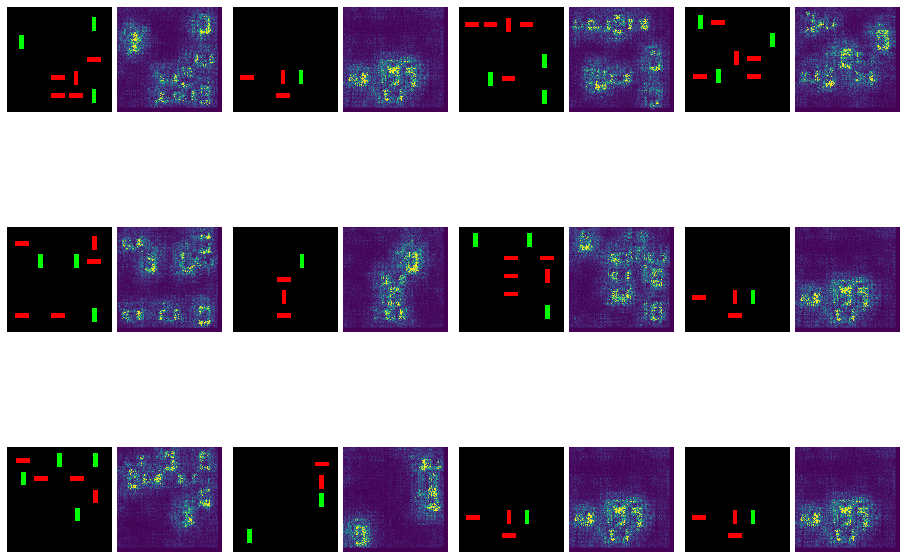

In [15]:
plot_img_w_saliency(num_samples=NUM_SAMPLES, figsize=(16, 16), sample_inds=target_present_wrong_inds)

In [16]:
right_target_present = np.nonzero(
    np.logical_and(np.equal(y_pred_all, y_test), np.equal(y_test, 1))
)[0]

In [17]:
right_inds = np.random.choice(right_target_present, 12)

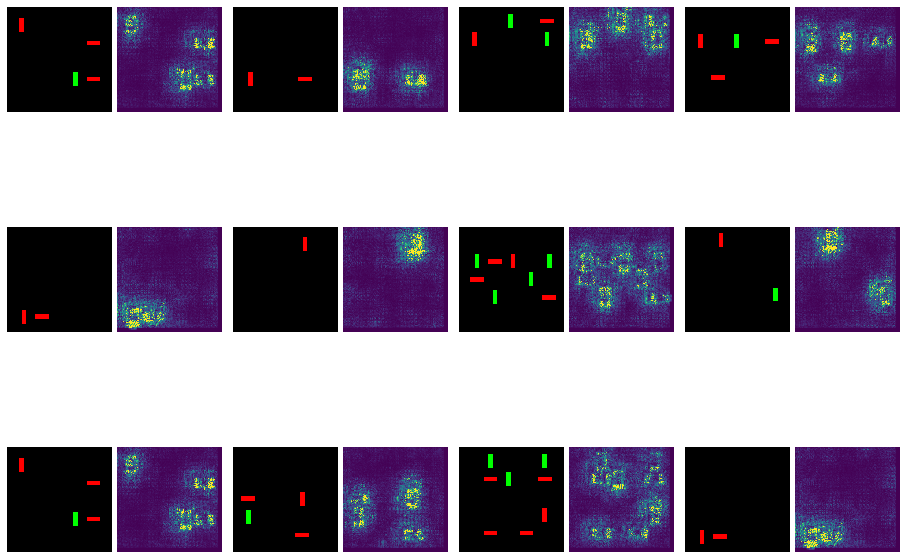

In [18]:
plot_img_w_saliency(num_samples=12, figsize=(16, 16), sample_inds=right_inds)

In [53]:
subplots = 2

def plot_img_w_gradcam(num_samples=9, figsize=(16, 4), cmap='viridis', sample_inds=None, save_as=None):
    if sample_inds is None:
        sample_inds = np.random.choice(np.arange(x_test.shape[0]), num_samples)

    fig = plt.figure(figsize=figsize)

    wh_plots = int(np.ceil(np.sqrt(12)))

    outer_grid = gridspec.GridSpec(wh_plots, wh_plots, wspace=0.05, hspace=0.05)
    for p, sample_ind in enumerate(sample_inds):
        inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[p], wspace=0.05, hspace=0.05)
        for s in range(2):
            ax = plt.Subplot(fig, inner_grid[s])
            if s == 0:
                im = x_test[sample_ind][:,:,::-1]
                ax.imshow(im)
                ax.set_xticks([])
                ax.set_yticks([])
            elif s == 1:
                im = VisualizeImageGrayscale(grad_cams_all[sample_ind])
                im_h = ax.imshow(im, cmap=cmap)
                ax.set_xticks([])
                ax.set_yticks([])
                # plt.colorbar(im_h, ax=ax)
                
            fig.add_subplot(ax)

    all_axes = fig.get_axes()
    if save_as:
        plt.savefig(save_as)

Where does the network look when it gets **target present** right?

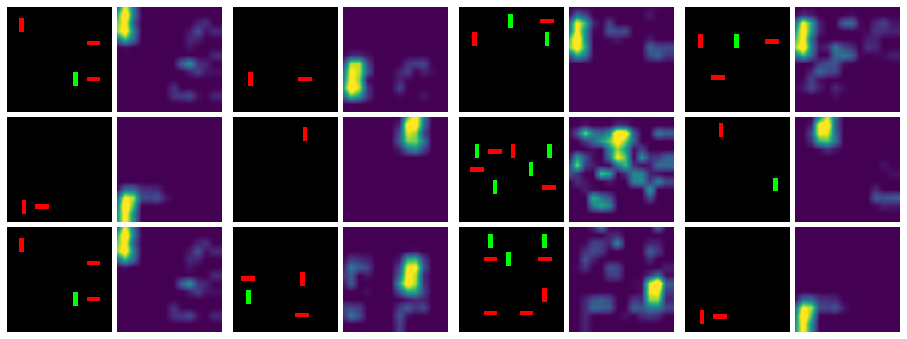

In [62]:
plot_img_w_gradcam(num_samples=12, figsize=(16, 8), sample_inds=right_inds, save_as='alexnet_finetune_RVvRHGV_target_present_hit.png')

Where does the network look when it gets **target present** wrong?

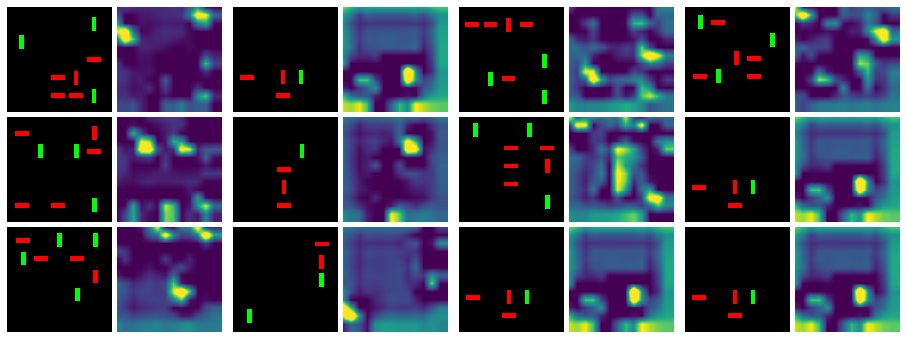

In [21]:
plot_img_w_gradcam(num_samples=12, figsize=(16, 8), sample_inds=target_present_wrong_inds, save_as='alexnet_finetune_RVvRHGV_target_present_miss.png')

In [22]:
target_absent_right = np.nonzero(
    np.logical_and(np.equal(y_pred_all, y_test), np.equal(y_test, 0))
)[0]
target_absent_right_inds = np.random.choice(target_absent_right, 12)

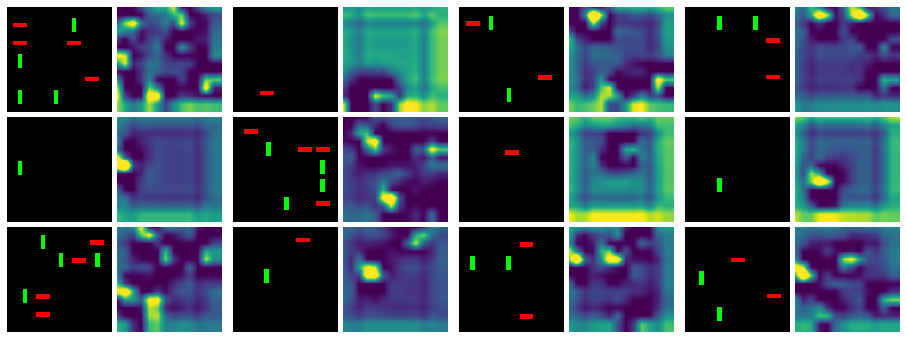

In [23]:
plot_img_w_gradcam(num_samples=12, figsize=(16, 8), sample_inds=target_absent_right_inds, save_as='alexnet_finetune_RVvRHGV_target_absent_hit.png')

In [28]:
target_absent_wrong = np.nonzero(
    np.logical_and(np.not_equal(y_pred_all, y_test), np.equal(y_test, 0))
)[0]
if np.size(target_absent_wrong) > 0:
    target_absent_wrong_inds = np.random.choice(target_absent_wrong, 2)
else:
    print('no cases where target absent was wrongly reported as present')

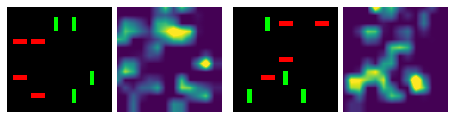

In [29]:
plot_img_w_gradcam(num_samples=2, figsize=(16, 8), sample_inds=target_absent_wrong_inds, save_as='alexnet_finetune_RVvRHGV_target_absent_miss.png')

In [47]:
from skimage.feature import blob_log

In [60]:
subplots = 3

def plot_img_gradcam_blobs(num_samples=9, figsize=(16, 4), cmap='viridis', sample_inds=None, save_as=None):
    if sample_inds is None:
        sample_inds = np.random.choice(np.arange(x_test.shape[0]), num_samples)

    fig = plt.figure(figsize=figsize)

    wh_plots = int(np.ceil(np.sqrt(12)))

    outer_grid = gridspec.GridSpec(wh_plots, wh_plots, wspace=0.05, hspace=0.05)
    for p, sample_ind in enumerate(sample_inds):
        inner_grid = gridspec.GridSpecFromSubplotSpec(1, subplots, subplot_spec=outer_grid[p], wspace=0.05, hspace=0.05)
        for s in range(subplots):
            ax = plt.Subplot(fig, inner_grid[s])
            if s == 0:
                im = x_test[sample_ind][:,:,::-1]
                ax.imshow(im)
                ax.set_xticks([])
                ax.set_yticks([])
            elif s == 1:
                im = VisualizeImageGrayscale(grad_cams_all[sample_ind])
                im_h = ax.imshow(im, cmap=cmap)
                ax.set_xticks([])
                ax.set_yticks([])
                # plt.colorbar(im_h, ax=ax)
            elif s == 2:
                im = VisualizeImageGrayscale(grad_cams_all[sample_ind])
                blobs_log = blob_log(im)
                ax.imshow(im)
                for blob in blobs_log:
                    y, x, r = blob
                    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
                    ax.add_patch(c)
                ax.set_axis_off()
                
            fig.add_subplot(ax)

    all_axes = fig.get_axes()
    if save_as:
        plt.savefig(save_as)

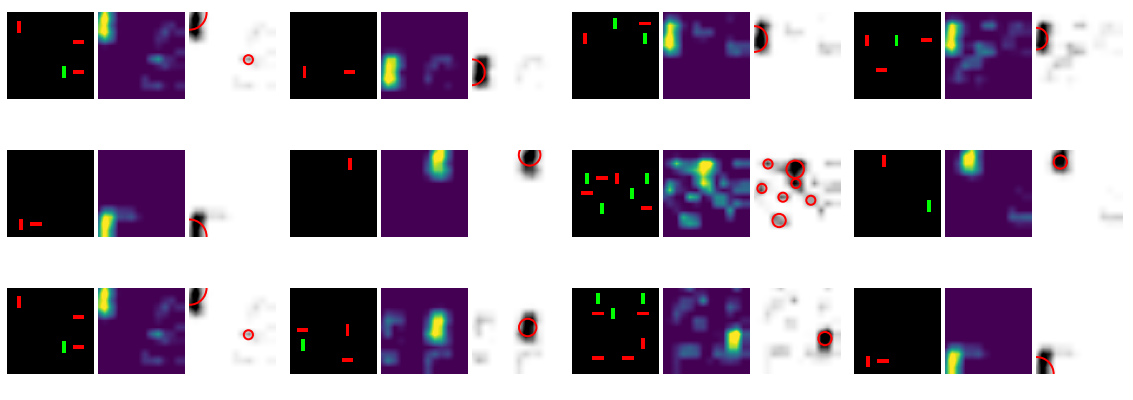

In [63]:
plot_img_gradcam_blobs(num_samples=12, figsize=(20, 10), sample_inds=right_inds, save_as='alexnet_finetune_RVvRHGV_target_present_hit_blobs.png')

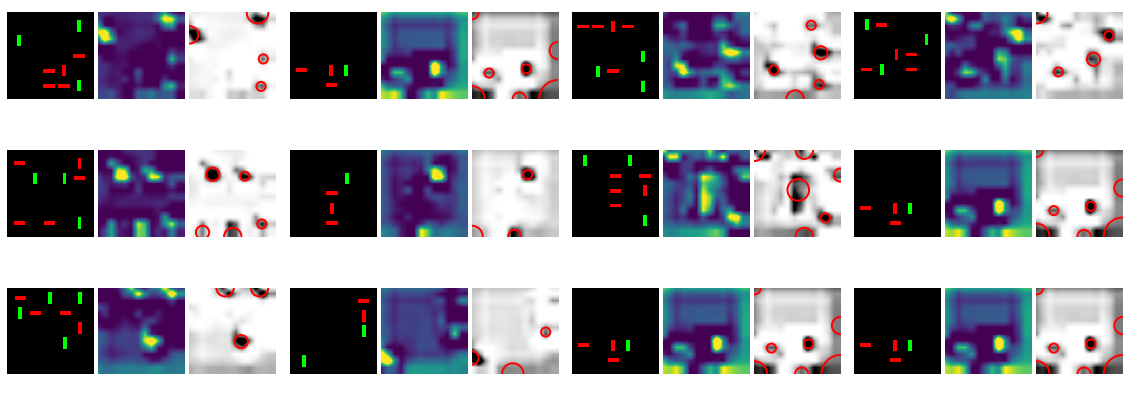

In [64]:
plot_img_gradcam_blobs(num_samples=12, figsize=(20, 10), sample_inds=target_present_wrong_inds, save_as='alexnet_finetune_RVvRHGV_target_present_misses_blobs.png')